In [ ]:
#TODO test if working for MOP

In [2]:
from evaluation.metrics import redundancy, yNN, d1_distance , d2_distance
from cProfile import label
from datetime import datetime
import pandas as pd
import os
from evaluation.Plots import plot_basic_dataset
from evaluation.metrics import yNN_timeseries
import numpy as np
from pathlib import Path
import platform
import sklearn
import torch
from models.CNN_TSNet import UCRDataset, train
from models.ResNet import ResNetBaseline, fit, get_all_preds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
from TSEvo.CounterfactualExplanation import Explanation
from evaluation import WachterEtAl, Wachter_CF
import pickle
from evaluation.Plots import plot_CF, plot_CF_Original, plot_CF_Original_Closest
from tslearn.datasets import UCR_UEA_datasets
import warnings
from evaluation.Instance_BasedCF_NativeGuide import NativeGuidCF
from deap import creator, base, algorithms, tools
from deap.benchmarks.tools import hypervolume, diversity, convergence
from tslearn.datasets import UCR_UEA_datasets
# TODO Pay Respect to shape ( Multivariate)
# TODO Ates
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin,window=0)

run_on =['GunPoint'] #['Coffee','CBF','ElectricDevices','ECG5000','GunPoint','FordA']
draw_plot=False
os_type= platform.system()
os.environ["CUDA_VISIBLE_DEVICES"]=""
mutation_type=['mutate_both']

for dataset in run_on: 
    if not os.path.isdir(f'./Results/Benchmarking/{dataset}'):
        os.mkdir(f'./Results/Benchmarking/{dataset}')
        
        if dataset in os.listdir('./Results/'):
            pass
        else:
            os.mkdir(f'./Results/{dataset}')
    X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
    train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
    test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2]) 
    enc1=pickle.load(open(f'./models/{dataset}/OneHotEncoder.pkl','rb'))
    test_y=enc1.transform(test_y.reshape(-1,1))
    n_classes = test_y.shape[1]
    if len(train_x.shape)==2:
        train_x=train_x.reshape(-1,train_x.shape[-2],train_x.shape[-1])
        test_x=test_x.reshape(-1,train_x.shape[-2],train_x.shape[-1])
    '''Load Model'''
    model = ResNetBaseline(in_channels=train_x.shape[-2], num_pred_classes=n_classes)
    model.load_state_dict(torch.load(f'./models/{dataset}/ResNet'))
    model.eval()
    
    y_pred= model(torch.from_numpy(test_x).float()).detach().numpy()
    test_y=y_pred
    '''Explanation Method'''
    from evaluation.COMTE import AtesCF
    from evaluation.Nun_CF import NativeGuideCF
    from evaluation.Wachter_CF import Wachter
    '''Initialize Methods'''
    nguide_cf=NativeGuideCF(model,np.array(train_x).shape, (test_x,test_y))
    ates= AtesCF(model, (test_x,test_y))
  

    '''Calculate'''
    ynn=[]
    ynn_timeseries=[]
    red=[]
    sal_01=[]
    sal_02=[]
    not_valid=0
    wachter_cf=[]
    ynn_wachter=[]
    ynn_timeseries_wachter=[]
    red_wachter=[]
    sal_01_wachter=[]
    sal_02_wachter=[]
    not_valid_wachter=0
    ynn_cfg=[]
    ynn_timeseries_cfg=[]
    red_cfg=[]
    sal_01_cfg=[]
    sal_02_cfg=[]
    cfg_cf=[]
    not_valid_cfg=0
    ynn_ib=[]
    ynn_timeseries_ib=[]
    red_ib=[]
    sal_01_ib=[]
    sal_02_ib=[]
    ib_cf=[]
    not_valid_ib=0
    max_iteration=len(test_y)
    #TODO add time Measure
    for i, item in enumerate(test_x):
        print('Image Number ',{i})
        observation_01=item
        label_01=np.array([test_y[i]])#test_y[0]
        if os.path.exists( f'./Results/mutate_both/{dataset}/Counterfactuals_{i}.pkl'):
            pop=pickle.load(open( f'./Results/mutate_both/{dataset}/Counterfactuals_{i}.pkl', "rb" ))
        else:
            break
        #input_ = torch.from_numpy(np.array(pop)).float()
        #output = torch.nn.functional.softmax(model(input_)).detach().numpy()
        y_target =np.argmax(test_y[i]) #output.argmax()
        mlmodel = model 
        counterfactuals = pop
        original = observation_01
        #print(y_target)
        #print(counterfactuals[0].output) 
        if y_target == np.argmax(counterfactuals[0].output):
            not_valid=not_valid+1
        ynn.append(yNN(counterfactuals, mlmodel,train_x,5)[0][0])
        ynn_timeseries.append(yNN_timeseries(counterfactuals, mlmodel,train_x,5)[0][0])
        red.append(redundancy(original, counterfactuals, mlmodel)[0])
        sal_01.append(d1_distance(observation_01,np.array(pop)))
        sal_02.append(d2_distance(observation_01,np.array(pop)))
    
        # Wachter et al . 
        #print(item.shape)
        #print(observation_01.shape)
        item = item.reshape(1,item.shape[-2],item.shape[-1])
        import time
        start_time = time.time()
        w=Wachter(model,(test_x,test_y))
        wachter_counterfactual, laberl_w=w.explain(item)#WachterEtAlwachter_recourse(mlmodel, item, y_target)
        end_time = time.time()
        print(f'This took {end_time-start_time}')
        wachter_cf.append(wachter_counterfactual)
        if not wachter_counterfactual is None:
            wachter_couterfactual=wachter_counterfactual.reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
            ynn_wachter.append(yNN(wachter_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
            ynn_timeseries_wachter.append(yNN_timeseries(wachter_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
            red_wachter.append(redundancy(original, wachter_counterfactual, mlmodel,labels=np.array([y_target]))[0])
            sal_01_wachter.append(d1_distance(observation_01,np.array(wachter_counterfactual)))
            sal_02_wachter.append(d2_distance(observation_01,np.array(wachter_counterfactual)))
            if laberl_w == np.argmax(label_01,axis=1):
                not_valid_wachter=not_valid_wachter+1
        else: 
             not_valid_wachter=not_valid_wachter+1

Image Number  {0}
This took 12.677502155303955
Image Number  {1}
This took 6.57660984992981
Image Number  {2}
This took 28.33884334564209
Image Number  {3}
This took 8.576214075088501
Image Number  {4}
This took 45.51110291481018
Image Number  {5}
This took 13.288203716278076
Image Number  {6}
This took 6.158310413360596
Image Number  {7}
This took 10.384891271591187
Image Number  {8}
This took 15.045092582702637
Image Number  {9}
This took 42.36138677597046
Image Number  {10}
This took 40.926557779312134
Image Number  {11}
This took 9.832609415054321
Image Number  {12}
This took 31.763782024383545
Image Number  {13}
This took 4.473188877105713
Image Number  {14}
This took 17.381351709365845
Image Number  {15}
This took 41.0758957862854
Image Number  {16}
This took 42.708807706832886
Image Number  {17}
This took 14.69998812675476
Image Number  {18}
This took 7.258446455001831
Image Number  {19}
This took 5.454721212387085
Image Number  {20}


In [3]:
#testing !
not_valid_wachter

0

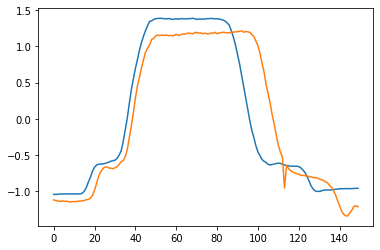

In [6]:
plt.plot(item.reshape(-1,1))
plt.plot(np.array(wachter_cf[0].reshape(-1,1)))